# Setup

In [40]:
# Only needed in Colab
import os
mode = -1
try:
    os.getlogin() # This will return an exception if ran in Google colab
    mode = 'local'
except:
    # Install necessary files and create necessary folders (Only when ran in Google Drive)
    !pip install snntorch
    !pip install torch
    !pip install gym
    !pip install gym[box2d]
    from google.colab import drive
    drive.mount('/content/drive')
    !mkdir tmp
    !cp "/content/drive/MyDrive/Colab Notebooks/dict9 LIF" "/content/tmp/"
    mode = 'colab'

In [41]:
import gym
import time
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import snntorch as snn
from snntorch import spikegen
from snntorch import surrogate

import warnings
warnings.filterwarnings('ignore')

In [42]:
### Parameters ###
env_name = 'LunarLander-v2'
filename = env_name + ".png"
outfilename = env_name + "scoreboard.txt"
model_file = "./tmp/dict9 LIF"

lr = 0.0005 # Learning rate
epsilon = 0.1
epsilon_end = 0.01
gamma = 0.99
batch_size = 64
n_games = 500 # Number of games to train for
n_hrs = 0.5 # Number of hours to train the model for
n_rounds = 5 # Number of competitive rounds to play

# Defining classes

In [43]:
class Net(nn.Module):
    def __init__(self, num_inputs, num_hidden, num_outputs, beta=0.95):
        super(Net, self).__init__()

        spike_grad1 = surrogate.fast_sigmoid()
        spike_grad2 = surrogate.fast_sigmoid()
        spike_grad3 = surrogate.fast_sigmoid()
        # Initialize layers
        self.fc1 = nn.Linear(num_inputs, num_hidden)
        self.lif1 = snn.Leaky(beta=beta, learn_threshold=False, spike_grad=spike_grad1)
        print(self.lif1)
        self.fc2 = nn.Linear(num_hidden, num_hidden)
        self.lif2 = snn.Leaky(beta=beta, learn_threshold=False, spike_grad=spike_grad2)
        self.fc3 = nn.Linear(num_hidden, num_outputs)
        self.lif3 = snn.Leaky(beta=beta, learn_beta=True, threshold=1e5, reset_mechanism="none", spike_grad=spike_grad3)

    def _convert_to_spikes(self, data):
        return snn.spikegen.delta(data, threshold=0.1, padding=False, off_spike=True)

    def createGauss(self, mins, maxes, numPerDim, amplMax, dims):
        self.amplMax = amplMax
        self.numPerDim = numPerDim
        self.M = []
        self.sigma = []
        for i in range(dims):
            M, sigma = np.linspace(mins[i], maxes[i], numPerDim, retstep=True)
            self.M.append(M)
            self.sigma += [sigma, ] * self.numPerDim
        self.M = torch.tensor(np.array(self.M).reshape(-1, self.numPerDim), dtype=torch.float)
        self.sigma = torch.tensor(np.array(self.sigma).reshape(-1, self.numPerDim), dtype=torch.float)

    def gaussianCurrents(self, data):
        x = data.unsqueeze(-1).repeat([1, 1, self.numPerDim])
        return (torch.exp(-1 / 2 * ((x - self.M) / self.sigma) ** 2) * self.amplMax).reshape(data.shape[0], -1)

    def forward(self, x, num_steps=16):

        x = self.gaussianCurrents(x)

        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()
        mem3 = self.lif3.init_leaky()

        # Record the final layer
        spk3_rec = []
        mem3_rec = []

        spk2_rec = []
        mem2_rec = []

        spk1_rec = []
        mem1_rec = []

        for step in range(num_steps):
            cur1 = self.fc1(x)
            spk1, mem1 = self.lif1(cur1, mem1, )
            cur2 = self.fc2(spk1)
            spk2, mem2 = self.lif2(cur2, mem2)
            cur3 = self.fc3(spk2)
            spk3, mem3 = self.lif3(cur3, mem3)
            spk3_rec.append(spk3)
            mem3_rec.append(mem3)
            spk2_rec.append(spk2)
            mem2_rec.append(mem2)
            spk1_rec.append(spk1)
            mem1_rec.append(mem1)


        return x, [torch.stack(spk1_rec, dim=0), torch.stack(spk2_rec, dim=0), torch.stack(spk3_rec, dim=0),
                torch.stack(mem1_rec, dim=0), torch.stack(mem2_rec, dim=0), torch.stack(mem3_rec, dim=0)], \
               torch.stack(mem3_rec, dim=0)
        # '''

class Agent(object):
    def __init__(self, lr, gamma, mem_size, n_actions, epsilon, batch_size, input_dims, epsilon_dec=0.99988,
                 epsilon_end=0.01, targetUpdateSteps=20, model_file="./tmp/dict9 LIF", q_dir='tmp\\q', visualize=False):
        self.visualize= visualize
        self.targetUpdateSteps = targetUpdateSteps
        self.action_space = [i for i in range(n_actions)]
        self.n_actions = n_actions
        self.gamma = gamma
        self.mem_size = mem_size
        self.mem_cntr = 0
        self.stepnum = 0
        self.epsilon = epsilon
        self.epsilon_dec = epsilon_dec
        self.epsilon_end = epsilon_end
        self.batch_size = batch_size
        self.model_file = model_file

        self.low = np.array(
            [
                # these are bounds for position
                # realistically the environment should have ended
                # long before we reach more than 50% outside
                -1.5,
                -1.5,
                # velocity bounds is 5x rated speed
                -5.0,
                -5.0,
                -np.pi,
                -5.0,
                -0.0,
                -0.0,
            ]
        ).astype(np.float32)
        self.high = np.array(
            [
                # these are bounds for position
                # realistically the environment should have ended
                # long before we reach more than 50% outside
                1.5,
                1.5,
                # velocity bounds is 5x rated speed
                5.0,
                5.0,
                np.pi,
                5.0,
                1.0,
                1.0,
            ]
        ).astype(np.float32)

        self.dtype = torch.float
        self.device = torch.device("cpu")

        gaussPerDim = 64
        hiddenSize = 128
        self.q_net = Net(input_dims[0] * gaussPerDim, hiddenSize, n_actions).to(self.device)
        self.q_net.createGauss(self.low, self.high, gaussPerDim, 1.0, input_dims[0])
        self.t_net = Net(input_dims[0] * gaussPerDim, hiddenSize, n_actions).to(self.device)
        self.t_net.createGauss(self.low, self.high, gaussPerDim, 1.0, input_dims[0])
        self.t_net.load_state_dict(self.q_net.state_dict())

        # self.loss = nn.CrossEntropyLoss()
        self.optimizer = torch.optim.Adam(self.q_net.parameters(), lr=lr, betas=(0.9, 0.999))
        # self.q_eval = DeepQNetwork(lr, n_actions, input_dims=input_dims, name='q_eval', chkpt_dir=q_dir)

        self.state_memory = np.zeros((self.mem_size, *input_dims))
        self.new_state_memory = np.zeros((self.mem_size, *input_dims))
        self.action_memory = np.zeros((self.mem_size, self.n_actions), dtype=np.int8)
        self.reward_memory = np.zeros(self.mem_size)
        self.terminal_memory = np.zeros(self.mem_size, dtype=np.int8)

    def store_transition(self, state, action, reward, state_, terminal):
        index = self.mem_cntr % self.mem_size
        self.state_memory[index] = state
        self.new_state_memory[index] = state_
        self.reward_memory[index] = reward
        actions = np.zeros(self.n_actions)
        actions[action] = 1.0
        self.action_memory[index] = actions
        self.terminal_memory[index] = 1 - terminal
        self.mem_cntr += 1

    def choose_action(self, state):
        state = state[np.newaxis, :]
        rand = np.random.random()
        # print(self.epsilon)
        if rand < self.epsilon:
            action = np.random.choice(self.action_space)
        else:
            with torch.no_grad():
                self.q_net.eval()
                gaussX, spikes, actions = self.q_net(torch.tensor(state, dtype=self.dtype).to(self.device))
                actions = actions.cpu()[-1, 0, :].detach().numpy()
                action = np.argmax(actions)
        # return action, [s.cpu().numpy() for s in spikes], gaussX.cpu().numpy()
        return action

    def learn(self):
        if self.mem_cntr > self.batch_size:
            max_mem = self.mem_cntr if self.mem_cntr < self.mem_size else self.mem_size

            batch = np.random.choice(max_mem, self.batch_size)
            state_batch = self.state_memory[batch]
            new_state_batch = self.new_state_memory[batch]
            action_batch = self.action_memory[batch]
            action_values = np.array(self.action_space, dtype=np.int8)
            action_indices = np.dot(action_batch, action_values)
            reward_batch = self.reward_memory[batch]
            terminal_batch = self.terminal_memory[batch]

            self.q_net.train()
            evalspikes, _, q_eval = self.q_net.forward(torch.tensor(state_batch, dtype=self.dtype).to(self.device))
            q_eval = q_eval[-1, :, :]

            self.t_net.eval()
            _, _, q_next = self.t_net.forward(torch.tensor(new_state_batch, dtype=self.dtype).to(self.device))

            q_next = q_next[-1, :, :]

            q_target = torch.clone(q_eval).detach()


            batch_index = np.arange(self.batch_size, dtype=np.int32)
            q_target[batch_index, action_indices] = (
                    torch.tensor(reward_batch, device=self.device) + torch.tensor(self.gamma, device=self.device) \
                    * torch.max(q_next, dim=1).values * torch.tensor(terminal_batch, device=self.device)).type(
                self.dtype).detach()

            criterion = nn.MSELoss()
            loss = criterion(q_eval, q_target)
            self.optimizer.zero_grad()
            loss.backward()

            for param in self.q_net.parameters():
                if param.grad is not None:
                    param.grad.data.clamp_(-1, 1)
            self.optimizer.step()

            self.epsilon = self.epsilon * self.epsilon_dec if self.epsilon > self.epsilon_end else self.epsilon_end

            if self.stepnum % self.targetUpdateSteps == 0:
                self.t_net.load_state_dict(self.q_net.state_dict())

            self.stepnum += 1

    def save_models(self):
        torch.save(self.q_net.state_dict(), self.model_file)

    def load_models(self):
        self.q_net.load_state_dict(torch.load(self.model_file, map_location=torch.device('cpu')))
        self.q_net.eval()

# Initialization

In [44]:
stime = time.time()
env = gym.make(env_name, render_mode='rgb_array')

n_actions = int(env.action_space.n)
n_input_dims = int(env.observation_space.shape[0]) # If the state space is not an 1-D vector then we need to change this

agent = Agent(gamma = gamma, epsilon = epsilon, lr = lr, input_dims = [n_input_dims], n_actions = n_actions,
              mem_size = 1000000, batch_size = batch_size, epsilon_end = epsilon_end)

scores = [] # Logged every episode
eps_history = [] # Logged every episode
avg_scores = [] # Logged every 10 episodes

if(os.path.exists(model_file)):
    agent.load_models()
else:
    agent.save_models()

state = agent.q_net.state_dict()
state["lif1.beta"] = torch.tensor(0.95,dtype=torch.float)
state["lif2.beta"] = torch.tensor(0.95, dtype=torch.float)
state["lif3.beta"] = torch.tensor(1.0, dtype=torch.float)
agent.q_net.load_state_dict(state)
print(agent.q_net.lif1.beta)

Leaky()
Leaky()
tensor(0.9500)


# Training

In [45]:
observation_, reward, done, info, score = 0, 0, 0, 0, 0
i = -1
while time.time() - stime < int(60 * 60 * n_hrs):
    i += 1
    done = False
    if i % 10 == 0 and i > 0:
        avg_score = np.mean(scores[max(0, i - 10):(i + 1)])
        avg_scores.append(avg_score)
        print('episode\t', i, '\tscore\t', score, '\taverage_score %.3f\t' % avg_score, '\tepsilon %.3f\t' % agent.epsilon)
        agent.save_models()
    else:
        print('episode\t', i, '\tscore\t', score)

    if(mode == 'colab'):
        observation = env.reset()
    else:
        observation, _ = env.reset()
    score = 0
    
    while not done:
        if i % 5 == 0:
            env.render()
        
        action = agent.choose_action(observation)

        if(mode == 'colab'):
            observation_, reward, done, info = env.step(action)
        else:
            observation_, reward, done, info, _ = env.step(action)
        score += reward
        agent.store_transition(observation, action, reward, observation_, int(done))
        observation = observation_
        agent.learn()
    scores.append(score)
    eps_history.append(agent.epsilon)

episode	 0 	score	 0
episode	 1 	score	 15.725259838228865
episode	 2 	score	 -325.23499037669654
episode	 3 	score	 -207.48285763410536
episode	 4 	score	 -309.9049837776544
episode	 5 	score	 -66.7728469048599
episode	 6 	score	 10.636236109437064
episode	 7 	score	 -165.14343716032226
episode	 8 	score	 -13.359004743962586
episode	 9 	score	 -121.6719671430879
episode	 10 	score	 -92.60778563478257 	average_score -127.582	 	epsilon 0.076	
episode	 11 	score	 181.97317796985146
episode	 12 	score	 -18.389329362125494
episode	 13 	score	 -111.30117258248448
episode	 14 	score	 -15.61685274295374
episode	 15 	score	 -196.8887957352191
episode	 16 	score	 -6.945968381904663
episode	 17 	score	 210.22923899723122
episode	 18 	score	 211.4100116761276
episode	 19 	score	 -220.84220426497356
episode	 20 	score	 129.74219210321792 	average_score 16.337	 	epsilon 0.053	
episode	 21 	score	 -57.870436478766095
episode	 22 	score	 -144.35144366823226
episode	 23 	score	 -186.0520786930888
epis

Total time:  2501.4070365428925


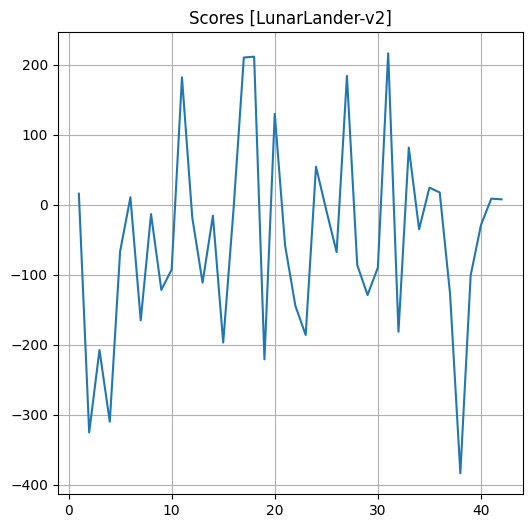

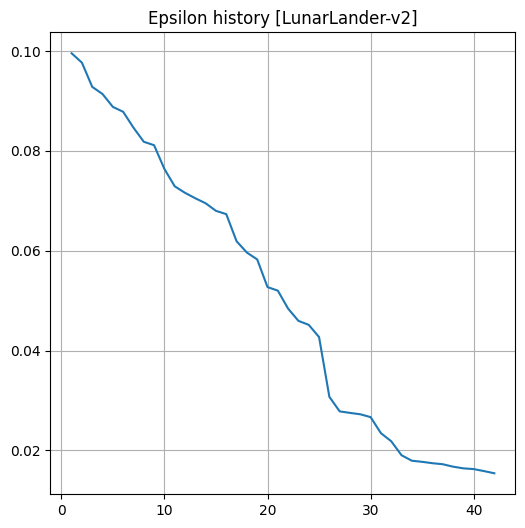

In [54]:
print("Total time: ", time.time() - stime)

x = [idx + 1 for idx in range(len(scores))]

plt.figure(figsize=(6,6))
plt.plot(x, scores)
plt.title('Scores ['+env_name+']')
plt.grid()
plt.show()

plt.figure(figsize=(6,6))
plt.plot(x, eps_history)
plt.title('Epsilon history ['+env_name+']')
plt.grid()
plt.show()

In [47]:
dfname = str(datetime.now()).split('.')[0].replace(' ', '_').replace('-', '_').replace(':', '_') + '_runlogs'
df = pd.DataFrame({'score': scores, 'Epsilon': eps_history})
df_avg = pd.DataFrame({'avg_score': avg_scores})

df.to_csv(dfname+'.csv', sep=';', header=True, index=False)
df_avg.to_csv(dfname+'_avg.csv', sep=';', header=True, index=False)

print("Done logging results")

Done logging results


# Competitive round

In [48]:
print('Starting competitive trials...')

compscores = 0
agent.load_models()
print('epsilon', agent.epsilon)

for i in range(n_rounds):
    done = False

    if(mode == 'colab'):
        observation = env.reset()
    else:
        observation, _ = env.reset()

    score = 0
    while not done:
        env.render()
        action = agent.choose_action(observation)

        if(mode == 'colab'):
            observation_, reward, done, info = env.step(action)
        else:
            observation_, reward, done, info, _ = env.step(action)

        agent.store_transition(observation, action, reward, observation_, int(done))
        observation = observation_
        score += reward
    compscores += score
    print("Competitive round ", i + 1, " Overall score ", compscores)

Starting competitive trials...
epsilon 0.015413102919839173
Competitive round  1  Overall score  -85.89530563094186
Competitive round  2  Overall score  -157.05924872592664
Competitive round  3  Overall score  -180.57173029086675
Competitive round  4  Overall score  -343.40373949499985
Competitive round  5  Overall score  -624.9070201540559


In [49]:
with open(outfilename, "w") as f:
    f.writelines("%s: %i\n" % ("Mikro Lander", compscores))